<a href="https://colab.research.google.com/github/Roger-G/Data-augmentation/blob/master/Bert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import package


In [0]:
!pip install transformers
!pip install pysnooper
import pandas as pd
import torch
from sklearn.metrics import multilabel_confusion_matrix
from torch import nn
from sklearn.metrics import precision_recall_fscore_support as score
import sys
from tqdm import trange
import numpy as np

import os
from collections import Counter
from IPython.display import clear_output
from torch.utils.data import Dataset
import seaborn as sns
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import torch
import pysnooper
# Load English tokenizer, tagger,  
# parser, NER and word vectors 
import re
from random import sample
from sklearn.utils import resample
import os.path as path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
absFilePath_aug = '/content/drive/My Drive/Data/Bert_ data augmentation-master/aug_data/rt-polaritydata/replacement/'
absFilePath = '/content/drive/My Drive/Data/Bert_ data augmentation-master/'
absFile_originaldata = '/content/drive/My Drive/Data/Bert_ data augmentation-master/datasets/rt-polaritydata/'
clear_output()

In [0]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"  
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
print("PyTorch version", torch.__version__)


PyTorch version 1.4.0


## Prepro_Data

In [0]:
class Prepro_Data(Dataset):
  
  def __init__(self, path, tokenizer, text_file_name, max_length=30):

    self.text, self.label = self.preprocess(text_file_name, max_length, path)    
    # print('text', len(self.text))
    self.tokenizer = tokenizer
    self.path = path

  def __getitem__(self, idx):
    
    text, label = self.text[idx], self.label[idx]
    tokens = text.split()
    word_pieces = ['[CLS]'] + tokens   
    ids = self.tokenizer.convert_tokens_to_ids(tokens)
    label_tensor = torch.tensor(label)
    tokens_tensor = torch.tensor(ids)
    segments_tensor = torch.zeros_like(tokens_tensor)  # (1, seq_len)

    return (tokens_tensor, label_tensor)
  
  def  __len__(self):      
    return len(self.text)

  @staticmethod
  def load_data(path_, FILE_NAME):
    
    print('FILE_NAME', FILE_NAME)
    df_train = pd.read_csv(os.path.join(path_,'train.tsv'), sep='\t',  error_bad_lines=False)
    df_train = df_train.dropna()
    num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())

    if FILE_NAME != 'oversampling':
      df = pd.read_csv(os.path.join(path_, FILE_NAME + '.tsv'), sep='\t',  error_bad_lines=False)    
      df = df.dropna()
    
    else:
      # 选出差额， 补到原数据上面
      df_over_samp = resample(df_train[df_train.label==0], n_samples=num_DA, random_state=100, replace=True)
      df = pd.concat([df_over_samp, df_train])

    if FILE_NAME != 'train' and FILE_NAME != 'dev' and FILE_NAME != 'oversampling':
      df_over_samp = resample(df, n_samples=num_DA, replace = False, random_state=10) 
      df = pd.concat([df_train, df_over_samp]) 
    
    else: 
      pass

    df = df.sample(frac=1, replace=False, random_state=102)  

    return df

  @classmethod
  def preprocess(clf, FILE_NAME, max_length, path):
    print('file_name in preprocess', FILE_NAME)
    data = clf.load_data(path, FILE_NAME)
    text, label = data.iloc[:, 0].values, data.iloc[:, 1].values
    print('text', len(text))

    return text, label

In [0]:
def create_mini_batch(samples):

    tokens_tensors = [s[0] for s in samples]
    if samples[0][1] is not None:
        label_ids = torch.stack([s[1] for s in samples])
    else:
        label_ids = None
        
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    masks_tensors = torch.zeros(tokens_tensors.shape,
                               dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    return tokens_tensors, masks_tensors, label_ids

## Model

In [0]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def load_model():
  
  NUM_LABELS = 3
  model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME,
                                                     num_labels=NUM_LABELS)
  model.to(device)
  return model

model = load_model()
# model.dropout = nn.Dropout(0.3)
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))



name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=3, bias=True)


## Utils

In [0]:
class utils():
  
  def __init__(self, EPOCHS):
    self.EPOCHS = EPOCHS

  def acc_loss(self, list_train_acc, list_val_acc, list_train_loss, list_val_loss):
    fig = plt.figure(figsize=(10, 5))
    
    
    ax1 = fig.add_subplot(1, 2, 1)
    sns.lineplot(ax=ax1, data=pd.DataFrame(list(zip(list_train_acc, list_val_acc)), columns=['training acc', 'validation acc'], index = range(1, len(list_val_acc)+1)))
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.locator_params(integer=True)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.lineplot(ax=ax2, data=pd.DataFrame(list(zip(list_train_loss, list_val_loss)), columns=['training loss', 'validation loss'], index = range(1, len(list_val_loss)+1)))
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.locator_params(integer=True)
    plt.show()
  
  @staticmethod
  def draw_final(eval_dic, test_list_name):
    
    for eval_name, eval_list in eval_dic.items():
      sns.set(style="white", context="talk")
      plt.figure(figsize=(10,5)) 
      g = sns.barplot(x=np.array(eval_list), y=np.array(test_list_name), palette="deep")
      ax=g
    
      for p in ax.patches:
        ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
          fontsize=12, color='gray', xytext=(10, 0), textcoords='offset points')
    
      # _ = g.set_xlim(0,1)
      ax.axhline(0, color="k", clip_on=False)
      ax.set_xlabel(eval_name)
      # ax.set_ylabel("Methods")

  @staticmethod
  def path_setting(task_name = 'twitter', tech_name = 'Bert_ data augmentation-master'):
    abspath = '/content/drive/My Drive/Data/'
    model_path = path.join(abspath, tech_name + '/save_model')
    dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
    save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))
    return model_path, dataset_path, save_path

  @staticmethod
  def eval_matrix(list_array_value):
    fig = plt.figure(figsize=(12, 5))
  
    for i, array_value in enumerate(list_array_value):
      df = pd.DataFrame(array_value, columns=["0", "1", "2"], index=range(1,len(array_value)+1))
      ax = fig.add_subplot(1, 3, i+1)
      sns.lineplot(data=df, palette="tab10", ax=ax)
      ax.set(xlabel='Epochs', ylabel=['precision', 'recall', 'fscore'][i])

    plt.show()
  
  @staticmethod
  def draw_other_final(list_array_dic, test_list):

    for eval_name, list_array in list_array_dic.items():
      fig1 = plt.figure(figsize=(10, 5))
      barWidth = 0.07
      colors = ['#2ec4b6', '#ccff66', '#ff6666', '#b2b1cf', '#e1f2fe', '#ffd6c0', '#ffa5a5', '#ec368d', '#440381', '#51E5FF']
      # Set position of bar on X axis
      r1 = np.arange(len(list_array[0]))
      plt.bar(r1, list_array[0], color=colors[0], width=barWidth, edgecolor='white', label=test_list[0])
      for i in range(1, len(list_array)):
        r1 = [x + barWidth for x in r1] 
        plt.bar(r1, list_array[i], color=colors[i], width=barWidth, edgecolor='white', label=test_list[i])  
    
      # Add xticks on the middle of the group bars
      plt.xlabel('class', fontweight='bold')
      plt.xticks([r + barWidth for r in range(len(list_array[0]))], ['negative', 'neutral', 'positive'])
      plt.ylabel(eval_name)
      # Create legend & Show graphic
      plt.legend()
      plt.show()
    


## Training

In [0]:
class train_pre():

  def __init__(self, model, file_name, task_name, tech_name, epochs):
    self.model = model
    self.file_name = file_name
    self.task_name = task_name
    self.tech_name = tech_name
    self.epochs = epochs

  def get_predictions(self):
    predictions = None
    correct = 0
    total = 0

    with torch.no_grad():
      label_list = list()
      pred_list = list()

      for data in self.train_loader:
        if next(self.model.parameters()).is_cuda:
          data = [t.to('cuda:0') for t in data if t is not None]                
        tokens_tensors, masks_tensors = data[:2]
        outputs = self.model(input_ids=tokens_tensors,
                        attention_mask=masks_tensors)
        logits = outputs[0]
        _, pred = torch.max(logits.data, 1)
        labels = data[2]      

        total += labels.size(0)
        correct += (pred == labels).sum().item()
        label_list.extend(labels.tolist())
        pred_list.extend(pred.tolist())

        if predictions is None:
          predictions = pred
        else:
          predictions = torch.cat((predictions, pred))
    # got all the evalution results for every class.
    precision, recall, fscore, _ = score(label_list, pred_list, labels=[0, 1, 2])
    # the second score function is to get average score of evaluation matrix.
    self.precision_avg, self.recall_avg, self.fscore_avg, _ = score(label_list, pred_list, labels=[0, 1, 2], average='micro' )
    acc = correct / total
    return predictions, acc, precision, recall, fscore

  def training(self, optimizer, patient=3):
  
    self.model.train()
    best_acc = 0
    sum_acc = 0
    best_loss = float("inf")
    num_train_samples = len(self.train_loader)
    num_val_samples = len(self.test_loader)
    draw_train_loss = []
    draw_train_acc = []
    draw_val_loss = []
    draw_val_acc = []
    draw_train_precision = []
    draw_val_precision = []
    draw_train_fscore = []
    draw_val_fscore = []
    draw_train_recall = []
    draw_val_recall = []
    count = 0

    for epoch in range(self.epochs):
      running_loss = 0.0
      val_loss = 0.0

      for data in self.train_loader:
        tokens_tensors, masks_tensors, labels = [t.to(device) for t in data]
        optimizer.zero_grad()
        outputs = self.model(input_ids=tokens_tensors,
                        attention_mask=masks_tensors,
                        labels=labels)
        
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss.detach()

      torch.cuda.empty_cache() 
      train_predictions, train_acc, self.precision, self.recall, self.fscore = self.get_predictions()

      for data in self.test_loader:
        tokens_tensors, masks_tensors, labels = [t.to(device) for t in data]
        optimizer.zero_grad()
        outputs = self.model(input_ids=tokens_tensors,
                        attention_mask=masks_tensors,
                        labels=labels)
        loss = outputs[0]
        val_loss += loss.item()   

      predictions, val_acc, precision, recall, fscore = self.get_predictions()
      # draw_val_fscore.append(fscore)
      # draw_val_recall.append(recall)
      # draw_val_precision.append(precision)

      if best_acc < val_acc:
        best_acc = val_acc
        count = 0

      if best_loss > val_loss/num_val_samples:
        best_loss = val_loss/num_val_samples
        count = 0
      
      print('[epoch %d] train_loss: %.3f, train_acc:%.3f, val_loss: %.3f, val_acc:%.3f' % 
            (epoch + 1, running_loss/num_train_samples, train_acc, val_loss/num_val_samples, val_acc))
      
      count += 1
      # print('count', count)
      if count > patient:
        torch.save({'state_dict': model.state_dict()}, path.join(self.model_path,'{}.pt'.format(self.file_name)))
        break

      draw_train_loss.append(running_loss/num_train_samples)
      draw_train_acc.append(train_acc)
      draw_val_loss.append(val_loss/num_val_samples)
      draw_val_acc.append(val_acc)

    torch.save({'state_dict': model.state_dict()}, path.join(self.model_path,'{}.pt'.format(self.file_name)))
    draw = utils(len(draw_train_acc))
    draw.acc_loss(draw_train_acc, draw_val_acc, draw_train_loss, draw_val_loss)
    # df_prec = pd.DataFrame(draw_val_precision, columns=['0', '1', '2'], index=range(1,len(draw_val_precision)+1))
    # df_recal = pd.DataFrame(draw_val_recall, columns=['0', '1', '2'], index=range(1,len(draw_val_recall)+1))
    # df_fscore = pd.DataFrame(draw_val_fscore, columns=['0', '1', '2'], index=range(1,len(draw_val_fscore)+1))

    # draw.eval_matrix([draw_val_precision, draw_val_recall, draw_val_fscore])
    return best_acc, best_loss

  def setting(self):

    self.model_path, dataset_path, save_path = utils.path_setting(self.task_name, self.tech_name)

    if self.tech_name == 'Bert_ data augmentation-master' and self.task_name == 'toxic':
      path_ = os.path.join(save_path, 'replacement')
    else:
      path_ = save_path

    optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-6)
    BATCH_SIZE = 64
    trainset = Prepro_Data(path=path_, tokenizer=tokenizer, text_file_name=self.file_name)
    self.train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

    _, train_acc, precision, recall, fscore = self.get_predictions()
    print('\n', 'before training model, the accuracy is {}'.format(train_acc))
    devset = Prepro_Data(path=path_, tokenizer=tokenizer, text_file_name='dev') # 对 dev data preprocess
    self.test_loader = DataLoader(devset, BATCH_SIZE, collate_fn=create_mini_batch)
    acc, loss = self.training(optimizer, patient=3)
    # _, acc = get_predictions(trained_model, testloader, compute_acc=True)
    print('After training model_{}, the accuracy is {}'.format(self.file_name, acc))

    return acc, loss, self.precision_avg, self.recall_avg, self.fscore_avg, self.precision, self.recall, self.fscore

## Run

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
file_name in preprocess train
FILE_NAME train
text 23353

 before training model, the accuracy is 0.40825589859975164
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 0.958, train_acc:0.586, val_loss: 0.875, val_acc:0.586
[epoch 2] train_loss: 0.797, train_acc:0.660, val_loss: 0.773, val_acc:0.659
[epoch 3] train_loss: 0.730, train_acc:0.686, val_loss: 0.743, val_acc:0.682
[epoch 4] train_loss: 0.696, train_acc:0.698, val_loss: 0.728, val_acc:0.699
[epoch 5] train_loss: 0.672, train_acc:0.710, val_loss: 0.724, val_acc:0.712
[epoch 6] train_loss: 0.649, train_acc:0.718, val_loss: 0.720, val_acc:0.722
[epoch 7] train_loss: 0.629, train_acc:0.733, val_loss: 0.718, val_acc:0.730
[epoch 8] train_loss: 0.611, train_acc:0.739, val_loss: 0.720, val_acc:0.743
[epoch 9] train_loss: 0.594, t

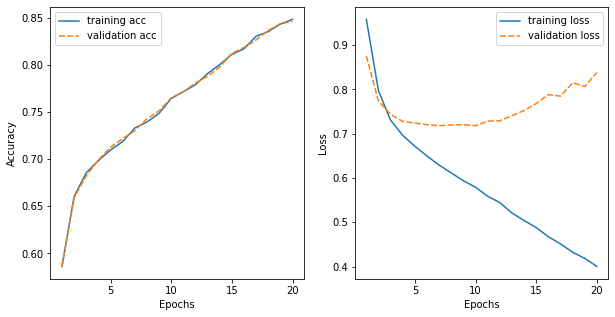

After training model_train, the accuracy is 0.8458870380679142
precision [0.82563824 0.85513268 0.84904206]
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
file_name in preprocess oversampling
FILE_NAME oversampling
text 30659

 before training model, the accuracy is 0.34352066277438925
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.027, train_acc:0.584, val_loss: 0.932, val_acc:0.585
[epoch 2] train_loss: 0.813, train_acc:0.672, val_loss: 0.831, val_acc:0.669
[epoch 3] train_loss: 0.722, train_acc:0.703, val_loss: 0.794, val_acc:0.702
[epoch 4] train_loss: 0.673, train_acc:0.714, val_loss: 0.774, val_acc:0.716
[epoch 5] train_loss: 0.637, train_acc:0.738, val_loss: 0.761, val_acc:0.739
[epoch 6] train_loss: 0.601, train_acc:0.753, val_loss: 0.761, val_acc:0.756
[epoch 7] train_loss: 0.570, train_acc:0.773, val_loss:

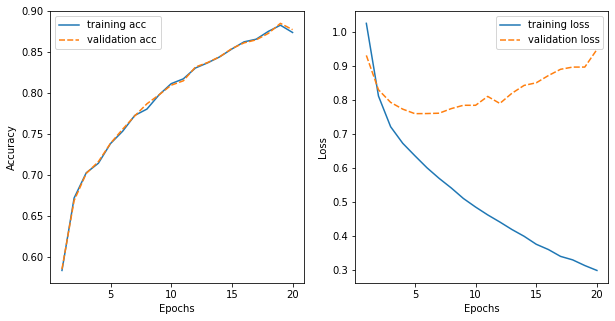

After training model_oversampling, the accuracy is 0.885090837926873
precision [0.97638713 0.77435303 0.9056985 ]
----------------------------------------------------------------------
Start to train model use the data : 2_rep_(fine)
----------------------------------------------------------------------
file_name in preprocess 2_rep_(fine)
FILE_NAME 2_rep_(fine)
text 30659

 before training model, the accuracy is 0.34635832871261296
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 0.992, train_acc:0.599, val_loss: 0.903, val_acc:0.598
[epoch 2] train_loss: 0.785, train_acc:0.681, val_loss: 0.828, val_acc:0.682
[epoch 3] train_loss: 0.709, train_acc:0.705, val_loss: 0.791, val_acc:0.703
[epoch 4] train_loss: 0.666, train_acc:0.728, val_loss: 0.770, val_acc:0.725
[epoch 5] train_loss: 0.630, train_acc:0.742, val_loss: 0.771, val_acc:0.742
[epoch 6] train_loss: 0.599, train_acc:0.761, val_loss: 0.770, val_acc:0.757
[epoch 7] train_loss: 0.571, train_acc:0.771, val

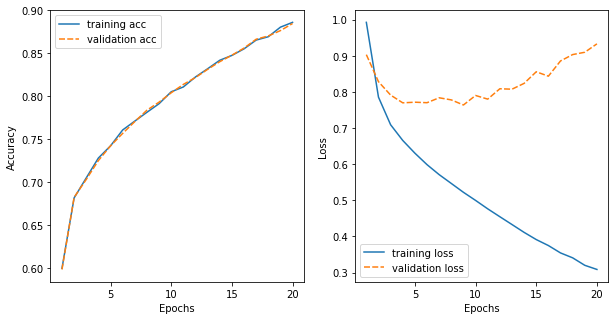

After training model_2_rep_(fine), the accuracy is 0.884732052578362
precision [0.9584597  0.85268647 0.83869897]
----------------------------------------------------------------------
Start to train model use the data : 3_rep_(fine)
----------------------------------------------------------------------
file_name in preprocess 3_rep_(fine)
FILE_NAME 3_rep_(fine)
text 30659

 before training model, the accuracy is 0.354871326527284
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 0.962, train_acc:0.632, val_loss: 0.884, val_acc:0.632
[epoch 2] train_loss: 0.759, train_acc:0.692, val_loss: 0.836, val_acc:0.692
[epoch 3] train_loss: 0.694, train_acc:0.713, val_loss: 0.784, val_acc:0.716
[epoch 4] train_loss: 0.653, train_acc:0.732, val_loss: 0.782, val_acc:0.737
[epoch 5] train_loss: 0.622, train_acc:0.748, val_loss: 0.779, val_acc:0.748
[epoch 6] train_loss: 0.592, train_acc:0.760, val_loss: 0.776, val_acc:0.765
[epoch 7] train_loss: 0.566, train_acc:0.776, val_l

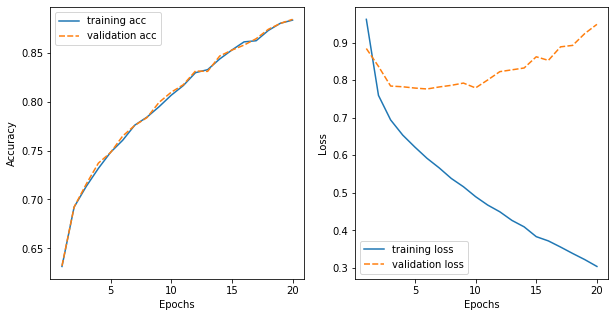

After training model_3_rep_(fine), the accuracy is 0.8840797155810691
precision [0.92560614 0.85012536 0.86811491]
----------------------------------------------------------------------
Start to train model use the data : 4_rep_(fine)
----------------------------------------------------------------------
file_name in preprocess 4_rep_(fine)
FILE_NAME 4_rep_(fine)
text 30659

 before training model, the accuracy is 0.3517074920904139
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 0.977, train_acc:0.615, val_loss: 0.916, val_acc:0.617
[epoch 2] train_loss: 0.787, train_acc:0.682, val_loss: 0.830, val_acc:0.680
[epoch 3] train_loss: 0.713, train_acc:0.706, val_loss: 0.797, val_acc:0.708
[epoch 4] train_loss: 0.668, train_acc:0.727, val_loss: 0.787, val_acc:0.729
[epoch 5] train_loss: 0.635, train_acc:0.740, val_loss: 0.795, val_acc:0.740
[epoch 6] train_loss: 0.606, train_acc:0.754, val_loss: 0.777, val_acc:0.757
[epoch 7] train_loss: 0.580, train_acc:0.770, val

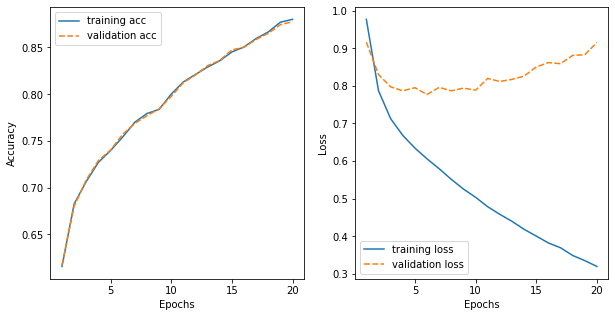

After training model_4_rep_(fine), the accuracy is 0.8774584950585472
precision [0.95978079 0.84264147 0.83003518]
----------------------------------------------------------------------
Start to train model use the data : 5_rep_(fine)
----------------------------------------------------------------------
file_name in preprocess 5_rep_(fine)
FILE_NAME 5_rep_(fine)
text 30659

 before training model, the accuracy is 0.2869304282592387
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.000, train_acc:0.594, val_loss: 0.906, val_acc:0.594
[epoch 2] train_loss: 0.792, train_acc:0.674, val_loss: 0.814, val_acc:0.674
[epoch 3] train_loss: 0.716, train_acc:0.704, val_loss: 0.784, val_acc:0.703
[epoch 4] train_loss: 0.670, train_acc:0.723, val_loss: 0.792, val_acc:0.720
[epoch 5] train_loss: 0.639, train_acc:0.739, val_loss: 0.775, val_acc:0.739
[epoch 6] train_loss: 0.607, train_acc:0.753, val_loss: 0.764, val_acc:0.751
[epoch 7] train_loss: 0.580, train_acc:0.769, val

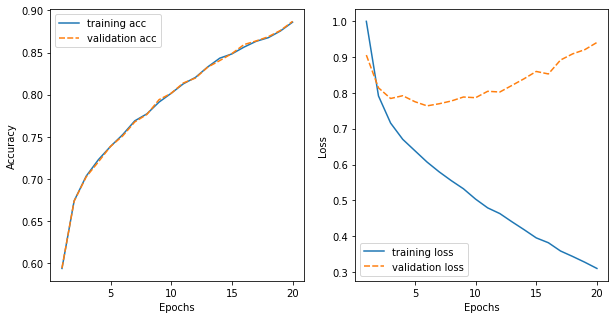

After training model_5_rep_(fine), the accuracy is 0.8870804657686161
precision [0.94863884 0.84760856 0.85524811]
----------------------------------------------------------------------
Start to train model use the data : 2_rep_(unfine)
----------------------------------------------------------------------
file_name in preprocess 2_rep_(unfine)
FILE_NAME 2_rep_(unfine)
text 30659

 before training model, the accuracy is 0.33853028474509933
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 0.964, train_acc:0.629, val_loss: 0.864, val_acc:0.626
[epoch 2] train_loss: 0.763, train_acc:0.690, val_loss: 0.805, val_acc:0.688
[epoch 3] train_loss: 0.692, train_acc:0.714, val_loss: 0.789, val_acc:0.714
[epoch 4] train_loss: 0.647, train_acc:0.727, val_loss: 0.769, val_acc:0.728
[epoch 5] train_loss: 0.614, train_acc:0.750, val_loss: 0.769, val_acc:0.749
[epoch 6] train_loss: 0.583, train_acc:0.761, val_loss: 0.758, val_acc:0.762
[epoch 7] train_loss: 0.557, train_acc:0.7

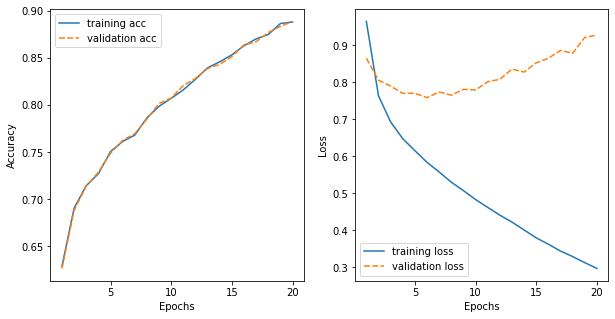

After training model_2_rep_(unfine), the accuracy is 0.8885482240125249
precision [0.95411508 0.86736862 0.83267189]
----------------------------------------------------------------------
Start to train model use the data : 3_rep_(unfine)
----------------------------------------------------------------------
file_name in preprocess 3_rep_(unfine)
FILE_NAME 3_rep_(unfine)
text 30659

 before training model, the accuracy is 0.3467497309109886
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 0.979, train_acc:0.602, val_loss: 0.922, val_acc:0.605
[epoch 2] train_loss: 0.785, train_acc:0.676, val_loss: 0.836, val_acc:0.684
[epoch 3] train_loss: 0.699, train_acc:0.710, val_loss: 0.808, val_acc:0.713
[epoch 4] train_loss: 0.650, train_acc:0.728, val_loss: 0.786, val_acc:0.730
[epoch 5] train_loss: 0.610, train_acc:0.745, val_loss: 0.793, val_acc:0.748
[epoch 6] train_loss: 0.581, train_acc:0.759, val_loss: 0.782, val_acc:0.761
[epoch 7] train_loss: 0.555, train_acc:0.

KeyboardInterrupt: ignored

In [0]:
%%time
if __name__ == "__main__":
  test_list = [
               'train', 
               'oversampling',
               '2_rep_(fine)', '3_rep_(fine)', '4_rep_(fine)', '5_rep_(fine)',
               '2_rep_(unfine)', '3_rep_(unfine)', '4_rep_(unfine)', '5_rep_(unfine)',
              ]
  task_name = 'twitter'
  tech_name = 'Bert_ data augmentation-master'
  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_prec = []
  list_recall = []
  list_fs = []
  for i, file_name in enumerate(test_list):
    print('-' * 70)
    print('Start to train model use the data : {}'.format(file_name))
    print('-' * 70)
    model = load_model()
    train = train_pre(model, file_name, task_name, tech_name, epochs=20)
    acc, loss, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = train.setting()
    # print('precision', precision)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

    acc_list.append(acc)
    loss_list.append(loss)
    list_prec.append(precision_avg)
    list_recall.append(recall_avg)
    list_fs.append(fscore_avg)
  
  print('acc_list', acc_list)
  print('loss_list', loss_list)
  print('precision_list', precision_list)
  print('recall_list', recall_list)
  print('fscore_list', fscore_list)
  print('average prec', list_prec)
  print('average recall', list_recall)
  print('average fs', list_fs)

  utils.draw_final({'loss': loss_list, 'accuracy': acc_list, 
                    'average fscore': list_fs, 'average precision': list_prec,
                    'average recall': list_recall,}, test_list)

  utils.draw_other_final( {'precision': precision_list, 
                    'recall': recall_list, 'fscore': fscore_list}, test_list)




In [0]:
 [np.array([0.        , 0.46699945, 0.42105263]), 0.44796573875803, np.array([0.46991404, 0.42538593, 0.38492063]), 0.4253098499673842]

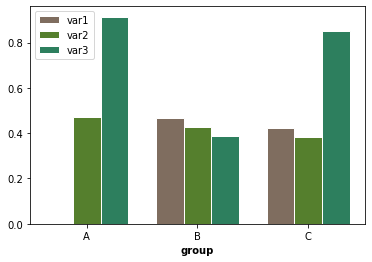

In [0]:
list_array = [np.array([0.        , 0.46699945, 0.42105263]),
              np.array([0.46991404, 0.42538593, 0.38492063]),
              np.array([0.91404, 0.38593, 0.8492063])]
df_recal = pd.DataFrame(list_array, columns=['0', '1', '2'])
barWidth = 0.25
 
# # set height of bar
# bars1 = [12, 30, 1, 8, 22]
# bars2 = [28, 6, 16, 5, 10]
# bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(list_array[1]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, list_array[0], color='#7f6d5f', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, list_array[1], color='#557f2d', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, list_array[2], color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(list_array[0]))], ['A', 'B', 'C'])
 
# Create legend & Show graphic
plt.legend()
plt.show()


r1 [0 1 2]


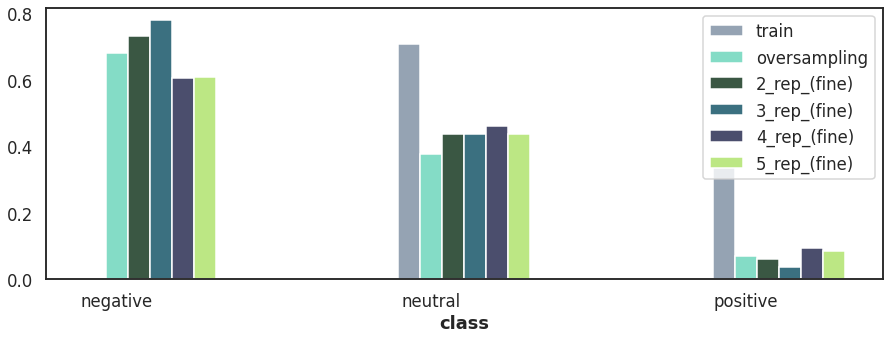

In [0]:
recall_list = [np.array([0.        , 0.70692884, 0.33991228]), np.array([0.68042142, 0.37535014, 0.07126168]), np.array([0.73080318, 0.43555974, 0.06206897]), np.array([0.77846425, 0.43838194, 0.03678161]), np.array([0.60458959, 0.46001881, 0.09310345]), np.array([0.60723742, 0.43838194, 0.08505747])]
fig1 = plt.figure(figsize=(15, 5))
barWidth = 0.07
colors = ['#95a3b3', '#84dcc6', '#3a5743', '#3b7080', '#4b4e6d', '#bce784', '#fcec52', '#2d7f5e', '#557f2d']
# Set position of bar on X axis
r1 = np.arange(len(recall_list[0]))
print('r1', r1)
plt.bar(r1, recall_list[0], color=colors[0], width=barWidth, edgecolor='white', label=test_list[0])
for i in range(1, len(recall_list)):
  r1 = [x + barWidth for x in r1] 
  plt.bar(r1, recall_list[i], color=colors[i], width=barWidth, edgecolor='white', label=test_list[i])  

# Add xticks on the middle of the group bars
plt.xlabel('class', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(recall_list[0]))], ['negative', 'neutral', 'positive'])
plt.legend()

In [0]:
r

NameError: ignored

In [0]:
test_list[2]

'2_rep_(fine)'

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
file_name in preprocess train
FILE_NAME train
text 23353

 before training model, the accuracy is 0.46627842247248746
file_name in preprocess dev
FILE_NAME dev
text 5839


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[epoch 1] train_loss: 1.019, train_acc:0.518, val_loss: 0.988, val_acc:0.514
[epoch 2] train_loss: 0.943, train_acc:0.575, val_loss: 0.896, val_acc:0.576
[epoch 3] train_loss: 0.841, train_acc:0.624, val_loss: 0.815, val_acc:0.627
[epoch 4] train_loss: 0.786, train_acc:0.652, val_loss: 0.781, val_acc:0.651
[epoch 5] train_loss: 0.750, train_acc:0.668, val_loss: 0.755, val_acc:0.669
[epoch 6] train_loss: 0.725, train_acc:0.681, val_loss: 0.754, val_acc:0.678
[epoch 7] train_loss: 0.705, train_acc:0.690, val_loss: 0.741, val_acc:0.690
[epoch 8] train_loss: 0.695, train_acc:0.697, val_loss: 0.737, val_acc:0.697
[epoch 9] train_loss: 0.679, train_acc:0.705, val_loss: 0.732, val_acc:0.706
[epoch 10] train_loss: 0.668, train_acc:0.709, val_loss: 0.725, val_acc:0.709
[epoch 11] train_loss: 0.659, train_acc:0.713, val_loss: 0.728, val_acc:0.714
[epoch 12] train_loss: 0.643, train_acc:0.718, val_loss: 0.726, val_acc:0.721
[epoch 13] train_loss: 0.634, train_acc:0.724, val_loss: 0.720, val_acc:0

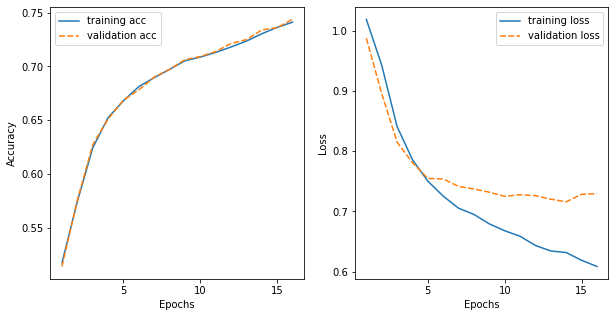

After training model_train, the accuracy is 0.7442298634008478
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
file_name in preprocess oversampling
FILE_NAME oversampling
text 30659

 before training model, the accuracy is 0.3555236635245768
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.075, train_acc:0.508, val_loss: 1.031, val_acc:0.505
[epoch 2] train_loss: 0.899, train_acc:0.640, val_loss: 0.867, val_acc:0.637
[epoch 3] train_loss: 0.786, train_acc:0.670, val_loss: 0.826, val_acc:0.670
[epoch 4] train_loss: 0.737, train_acc:0.693, val_loss: 0.791, val_acc:0.691
[epoch 5] train_loss: 0.706, train_acc:0.700, val_loss: 0.769, val_acc:0.701
[epoch 6] train_loss: 0.684, train_acc:0.715, val_loss: 0.767, val_acc:0.713
[epoch 7] train_loss: 0.662, train_acc:0.725, val_loss: 0.764, val_acc:0.724
[epoch 8] train_loss: 0.

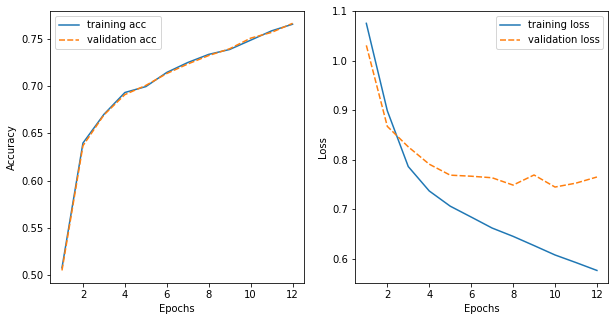

After training model_oversampling, the accuracy is 0.7730845754916991
----------------------------------------------------------------------
Start to train model use the data : 2_rep_(fine)
----------------------------------------------------------------------
file_name in preprocess 2_rep_(fine)
FILE_NAME 2_rep_(fine)
text 30659

 before training model, the accuracy is 0.360220489905085
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.056, train_acc:0.535, val_loss: 1.016, val_acc:0.530
[epoch 2] train_loss: 0.900, train_acc:0.628, val_loss: 0.896, val_acc:0.631
[epoch 3] train_loss: 0.794, train_acc:0.666, val_loss: 0.838, val_acc:0.668
[epoch 4] train_loss: 0.743, train_acc:0.687, val_loss: 0.818, val_acc:0.688
[epoch 5] train_loss: 0.712, train_acc:0.701, val_loss: 0.807, val_acc:0.699
[epoch 6] train_loss: 0.686, train_acc:0.712, val_loss: 0.789, val_acc:0.711
[epoch 7] train_loss: 0.667, train_acc:0.721, val_loss: 0.784, val_acc:0.721
[epoch 8] train_lo

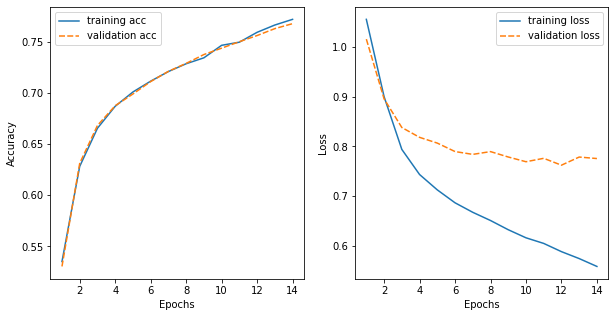

After training model_2_rep_(fine), the accuracy is 0.7760200919795166
----------------------------------------------------------------------
Start to train model use the data : 3_rep_(fine)
----------------------------------------------------------------------
file_name in preprocess 3_rep_(fine)
FILE_NAME 3_rep_(fine)
text 30659

 before training model, the accuracy is 0.28931145829935745
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.054, train_acc:0.533, val_loss: 1.030, val_acc:0.533
[epoch 2] train_loss: 0.908, train_acc:0.620, val_loss: 0.914, val_acc:0.622
[epoch 3] train_loss: 0.801, train_acc:0.663, val_loss: 0.855, val_acc:0.664
[epoch 4] train_loss: 0.748, train_acc:0.683, val_loss: 0.827, val_acc:0.687
[epoch 5] train_loss: 0.715, train_acc:0.700, val_loss: 0.808, val_acc:0.699
[epoch 6] train_loss: 0.688, train_acc:0.713, val_loss: 0.806, val_acc:0.714
[epoch 7] train_loss: 0.670, train_acc:0.723, val_loss: 0.790, val_acc:0.723
[epoch 8] train_

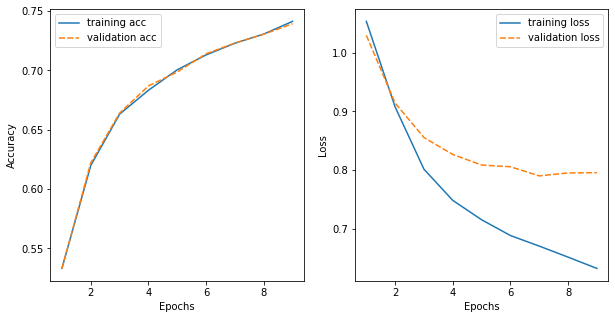

After training model_3_rep_(fine), the accuracy is 0.7466323102514759
----------------------------------------------------------------------
Start to train model use the data : 4_rep_(fine)
----------------------------------------------------------------------
file_name in preprocess 4_rep_(fine)
FILE_NAME 4_rep_(fine)
text 30659

 before training model, the accuracy is 0.29877034476010306
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.022, train_acc:0.574, val_loss: 0.968, val_acc:0.572
[epoch 2] train_loss: 0.858, train_acc:0.637, val_loss: 0.882, val_acc:0.636
[epoch 3] train_loss: 0.785, train_acc:0.663, val_loss: 0.842, val_acc:0.667
[epoch 4] train_loss: 0.743, train_acc:0.685, val_loss: 0.830, val_acc:0.685
[epoch 5] train_loss: 0.712, train_acc:0.700, val_loss: 0.808, val_acc:0.698
[epoch 6] train_loss: 0.689, train_acc:0.711, val_loss: 0.803, val_acc:0.709
[epoch 7] train_loss: 0.667, train_acc:0.719, val_loss: 0.791, val_acc:0.723
[epoch 8] train_

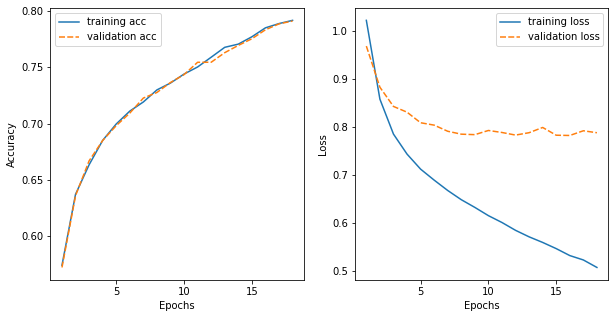

After training model_4_rep_(fine), the accuracy is 0.7988192700349
----------------------------------------------------------------------
Start to train model use the data : 5_rep_(fine)
----------------------------------------------------------------------
file_name in preprocess 5_rep_(fine)
FILE_NAME 5_rep_(fine)
text 30659

 before training model, the accuracy is 0.3482501060047621
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.041, train_acc:0.543, val_loss: 1.010, val_acc:0.540
[epoch 2] train_loss: 0.894, train_acc:0.620, val_loss: 0.894, val_acc:0.615
[epoch 3] train_loss: 0.806, train_acc:0.655, val_loss: 0.860, val_acc:0.654
[epoch 4] train_loss: 0.757, train_acc:0.678, val_loss: 0.830, val_acc:0.676
[epoch 5] train_loss: 0.726, train_acc:0.695, val_loss: 0.812, val_acc:0.694
[epoch 6] train_loss: 0.699, train_acc:0.705, val_loss: 0.805, val_acc:0.703
[epoch 7] train_loss: 0.682, train_acc:0.714, val_loss: 0.787, val_acc:0.712
[epoch 8] train_loss

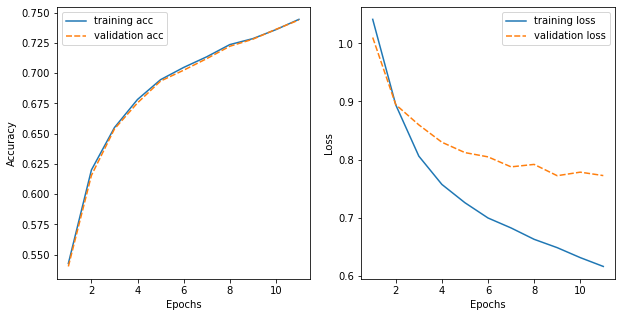

After training model_5_rep_(fine), the accuracy is 0.7523076421279233
----------------------------------------------------------------------
Start to train model use the data : 2_rep_(unfine)
----------------------------------------------------------------------
file_name in preprocess 2_rep_(unfine)
FILE_NAME 2_rep_(unfine)
text 30659

 before training model, the accuracy is 0.28898528980071103
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.065, train_acc:0.508, val_loss: 1.041, val_acc:0.507
[epoch 2] train_loss: 0.931, train_acc:0.595, val_loss: 0.930, val_acc:0.591
[epoch 3] train_loss: 0.822, train_acc:0.652, val_loss: 0.875, val_acc:0.652
[epoch 4] train_loss: 0.762, train_acc:0.677, val_loss: 0.833, val_acc:0.676
[epoch 5] train_loss: 0.718, train_acc:0.691, val_loss: 0.807, val_acc:0.694
[epoch 6] train_loss: 0.693, train_acc:0.707, val_loss: 0.792, val_acc:0.706
[epoch 7] train_loss: 0.668, train_acc:0.717, val_loss: 0.797, val_acc:0.715
[epoch 8] 

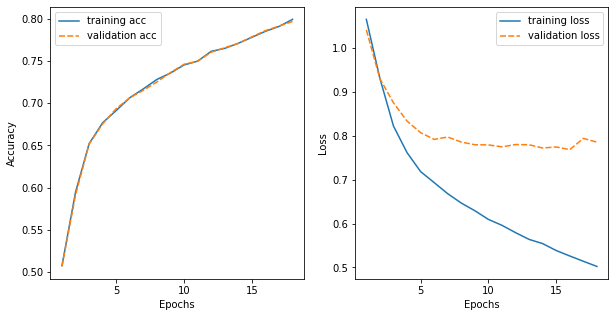

After training model_2_rep_(unfine), the accuracy is 0.8008415147265077
----------------------------------------------------------------------
Start to train model use the data : 3_rep_(unfine)
----------------------------------------------------------------------
file_name in preprocess 3_rep_(unfine)
FILE_NAME 3_rep_(unfine)
text 30659

 before training model, the accuracy is 0.3408786979353534
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.052, train_acc:0.531, val_loss: 1.028, val_acc:0.531
[epoch 2] train_loss: 0.897, train_acc:0.618, val_loss: 0.919, val_acc:0.618
[epoch 3] train_loss: 0.800, train_acc:0.661, val_loss: 0.864, val_acc:0.660
[epoch 4] train_loss: 0.741, train_acc:0.681, val_loss: 0.835, val_acc:0.686
[epoch 5] train_loss: 0.706, train_acc:0.702, val_loss: 0.818, val_acc:0.699
[epoch 6] train_loss: 0.675, train_acc:0.712, val_loss: 0.813, val_acc:0.713
[epoch 7] train_loss: 0.654, train_acc:0.721, val_loss: 0.808, val_acc:0.720
[epoch 8]

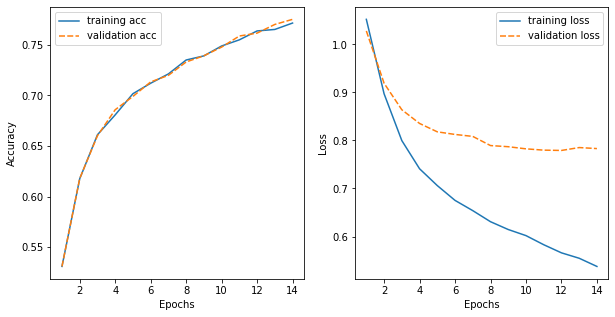

After training model_3_rep_(unfine), the accuracy is 0.7852506604912097
----------------------------------------------------------------------
Start to train model use the data : 4_rep_(unfine)
----------------------------------------------------------------------
file_name in preprocess 4_rep_(unfine)
FILE_NAME 4_rep_(unfine)
text 30659

 before training model, the accuracy is 0.352425062787436
file_name in preprocess dev
FILE_NAME dev
text 5839
[epoch 1] train_loss: 1.021, train_acc:0.565, val_loss: 0.997, val_acc:0.563
[epoch 2] train_loss: 0.862, train_acc:0.631, val_loss: 0.903, val_acc:0.629
[epoch 3] train_loss: 0.782, train_acc:0.666, val_loss: 0.845, val_acc:0.667
[epoch 4] train_loss: 0.729, train_acc:0.690, val_loss: 0.826, val_acc:0.691
[epoch 5] train_loss: 0.696, train_acc:0.709, val_loss: 0.807, val_acc:0.703
[epoch 6] train_loss: 0.664, train_acc:0.717, val_loss: 0.794, val_acc:0.718
[epoch 7] train_loss: 0.646, train_acc:0.726, val_loss: 0.779, val_acc:0.725
[epoch 8] 

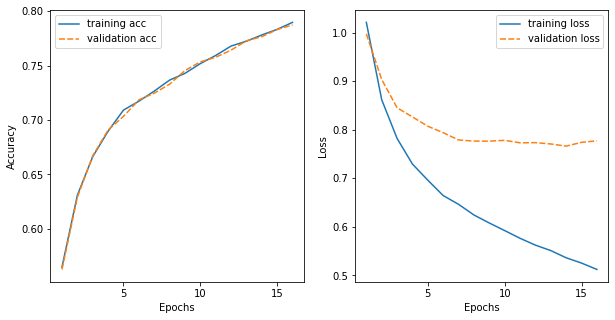

After training model_4_rep_(unfine), the accuracy is 0.7961120714961349
----------------------------------------------------------------------
Start to train model use the data : 5_rep_(unfine)
----------------------------------------------------------------------
file_name in preprocess 5_rep_(unfine)
FILE_NAME 5_rep_(unfine)
text 30659

 before training model, the accuracy is 0.3081313806712548
file_name in preprocess dev
FILE_NAME dev
text 5839


In [0]:
%%time
if __name__ == "__main__":
  test_list = [
               'train', 
               'oversampling',
               '2_rep_(fine)', '3_rep_(fine)', '4_rep_(fine)', '5_rep_(fine)',
               '2_rep_(unfine)', '3_rep_(unfine)', '4_rep_(unfine)', '5_rep_(unfine)',
              ]
  task_name = 'twitter'
  tech_name = 'Bert_ data augmentation-master'
  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  for i, file_name in enumerate(test_list):
    print('-' * 70)
    print('Start to train model use the data : {}'.format(file_name))
    print('-' * 70)
    model = load_model()
    train = train_pre(model, file_name, task_name, tech_name, epochs=20)
    acc, loss, precision_avg, recall_avg, fscore_avg = train.setting()
    acc_list.append(acc)
    loss_list.append(loss)
    precision_list.append(precision_avg)
    recall_list.append(recall_avg)
    fscore_list.append(fscore_avg)

  utils.draw_final(loss_list, test_list, 'Loss')  
  utils.draw_final(precision_list, test_list, 'Precision')
  utils.draw_final(recall_list, test_list, 'recall')
  utils.draw_final(fscore_list, test_list, 'Fscore')

  print('acc_list', acc_list)
  print('loss_list', loss_list)
  print('precision_list', precision_list)
  print('recall_list', recall_list)
  print('fscore_list', fscore_list)

## full data result

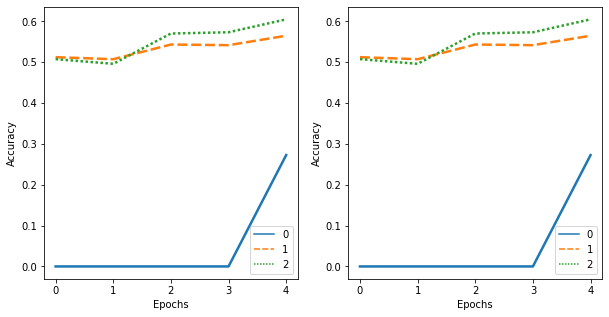

In [0]:
te = [np.array([0.        , 0.51247251, 0.50766335]), np.array([0.        , 0.50746455, 0.49618736]), np.array([0.        , 0.5433876 , 0.57040179]), np.array([0.        , 0.54184815, 0.57342823]), np.array([0.27272727, 0.56497294, 0.60506968])]
# te_list = [t.tolist() for t in te]
# print(te_list)
# # sns.lineplot(data=data, palette="tab10", linewidth=2.5)
# class_0 = [s[0] for s in te_list]
# class_1 = [s[1] for s in te_list]
# class_2 = [s[2] for s in te_list]
# f, axes = plt.subplots(1, 2)fig = plt.figure(figsize=(10, 5))

fig = plt.figure(figsize=(10, 5))

# ax = sns.lineplot(data=pd.DataFrame(list(zip(class_0, class_1, class_2)), columns=["0", "1", "2"], index = range(1, len(class_2)+1)))
df = pd.DataFrame(te, columns=["0", "1", "2"])
for i in range(1, 3):
  ax = fig.add_subplot(1, 2, i)
  sns.lineplot(data=df, palette="tab10", linewidth=2.5)
  ax.set(xlabel='Epochs', ylabel='Accuracy')
# pred_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# label_list = [0, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 1, 0, 2]
# score(label_list, pred_list, average='macro')



In [0]:
%%time
if __name__ == "__main__":
  test_list = [
               'train', 
               'oversampling',
               '1_rep_fine', '2_rep_fine', '3_rep_fine', '4_rep_fine',
               '1_rep_unfine', '2_rep_unfine', '3_rep_unfine', '4_rep_unfine'
              ]
  task_name = 'twitter'
  tech_name = 'Bert_ data augmentation-master'
  acc_list = []
  loss_list = []
  for i, file_name in enumerate(test_list):
    print('-' * 70)
    print('Start to train model use the data : {}'.format(file_name))
    print('-' * 70)
    model = load_model()
    acc, loss = setting(model, file_name, task_name, tech_name)
    acc_list.append(acc)
    loss_list.append(loss)

  utils.draw_final(loss_list, test_list)

  print(acc_list)
  print('loss_list', loss_list)


In [0]:
def draw_final(loss_list, test_list_name):
  sns.set(style="white", context="talk")
  plt.figure(figsize=(10,5)) 
  g = sns.barplot(x=np.array(loss_list), y=np.array(test_list_name), palette="deep")
  ax=g
#annotate axis = seaborn axis
  for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
      fontsize=12, color='gray', xytext=(10, 0), textcoords='offset points')
  
  _ = g.set_xlim(0,1)
  ax.axhline(0, color="k", clip_on=False)
  ax.set_xlabel("Loss")
  ax.set_ylabel("Methods")
  



In [0]:
x_axis = ["A", "B","C","D","E","F"]
y_axis = [78.5, 79.6, 81.6, 75.4, 78.3, 79.6]

plt.ylabel('Accuracy')
plt.title('Accuracy of Classifier')

g=sns.barplot(x_axis, y_axis, color="red")
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
  print('y', "%.2f" % p.get_height())
  print('x', p.get_width()/2 + p.get_x())
  ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
      textcoords='offset points')
_ = g.set_ylim(0,120)

Text(0, 0.5, 'Methods')

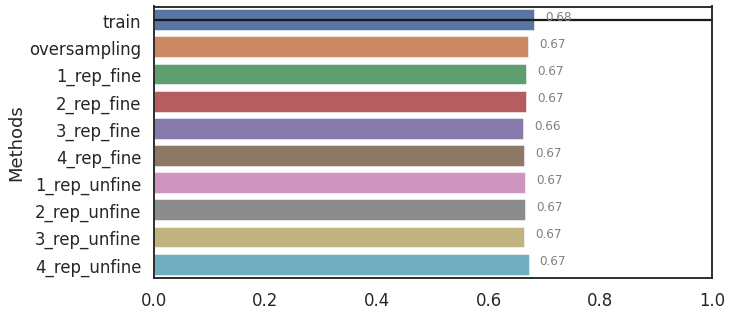

In [0]:

acc_list = [0.6834911881069416, 0.6728210046756984, 0.6683850857211365, 0.6683850857211365, 0.6638292770651001, 0.6652679534827959, 0.6674259681093394, 0.6668265196019662, 0.6657475122886944, 0.6734204531830715]
list_val_loss = [0.634911881069416, 0.678210046756984, 0.683850857211365, 0.683850857211365, 0.668292770651001, 0.66526795347959, 0.674259681093394, 0.8265196019662, 0.475122886944, 0.6734204531830715]
test_list = [
              'train', 
              'oversampling',
              '1_rep_fine', '2_rep_fine', '3_rep_fine', '4_rep_fine',
              '1_rep_unfine', '2_rep_unfine', '3_rep_unfine', '4_rep_unfine'
            ]

sns.set(style="white", context="talk")
plt.figure(figsize=(10,5)) 
g = sns.barplot(x=np.array(acc_list), y=np.array(test_list), palette="deep")
ax=g

for p in ax.patches:
  ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
    fontsize=12, color='gray', xytext=(10, 0), textcoords='offset points')

_ = g.set_xlim(0,1)
ax.axhline(0, color="k", clip_on=False)
# ax.set_xlabel('train')
ax.set_ylabel("Methods")

# def draw_loss(list_train_loss, list_val_loss, columns=['training loss', 'validation loss']):
#     ax = sns.lineplot(data=pd.DataFrame(list(zip(list_train_loss, list_val_loss)), columns=columns))
#     ax.set(xlabel='Epochs', ylabel='Loss')
#     ax.locator_params(integer=True)
#     plt.show()

# ax = sns.lineplot(data=pd.DataFrame(list(zip(acc_list, list_val_loss))))
# ax.locator_params(integer = True)